We run the premium pricing simulations for two reasons. The first is that we want to visually explain how our premium pricing works. The second is that we want to define constant values in a way that meet our criteria. Based on our criteria, we define constant values below:

- MIN_BASE_PREMIUM
- LEVERAGE_RATIO_CEILING
- LEVERAGE_RATIO_FLOOR
- BUFFER
- CURVATURE
- RISK_PREMIUM_PERCENT

In [124]:
import math
from matplotlib import pyplot as plt
import numpy as np

In [125]:
# constant values for premium the pricing formula

# user inputs 
DURATION = 1
PROTECTION_AMOUNT = 1

# predefined values
CURVATURE = 1/20
LEVERAGE_RATIO_FLOOR = 0.1
LEVERAGE_RATIO_CEILING = 0.2
BUFFER = 0.05
LEVERAGE_RATIO_MIN = LEVERAGE_RATIO_FLOOR - BUFFER
LEVERAGE_RATIO_MAX = LEVERAGE_RATIO_CEILING + BUFFER
MIN_CARAPACE_RISK_PREMIUM = 0.02
UNDERLYING_RISK_PREMIUM_PERCENT = 0.1
PROTECTION_BUYER_APY = 0.17
MINIMUM_STOKEN_UNDERLYING = 400000
MINIMUM_TOTAL_PROTECTION_AMOUNT = 2000000

# market driven values
LEVERAGE_RATIO = 0.15

# flags
INSUFFICIENT_STOKEN_UNDERLYING = -1
INSUFFICIENT_TOTAL_PROTECTION_AMOUNT = -2

In [126]:
# the leverage ratio formula

# When the Carapace Protocol starts a new pool, there are the minimal sToken underlying from protection sellers and the minimal total protection amount in the pool. If the sToken underlying is less than the minimum sToken underlying or the total protection amount is less than minimum total protection amount, the premium is min_base_premium + risk_premium. 

def leverage_ratio(
    sToken_underlying=MINIMUM_STOKEN_UNDERLYING,
    total_protection_amount=MINIMUM_TOTAL_PROTECTION_AMOUNT
):
    if(sToken_underlying < MINIMUM_STOKEN_UNDERLYING):
        return INSUFFICIENT_STOKEN_UNDERLYING
    if(total_protection_amount < MINIMUM_TOTAL_PROTECTION_AMOUNT):
        return INSUFFICIENT_TOTAL_PROTECTION_AMOUNT
    return sToken_underlying/total_protection_amount
    # where sToken_underlying = locked_capital + accrued_premiums - default_payouts


In [127]:
leverage_ratio(1000000, 2000000)


0.5

In [128]:
# base premium formula

def carapace_risk_premium(
    duration=DURATION,
    curvature=CURVATURE,
    leverage_ratio=LEVERAGE_RATIO,
    leverage_ratio_min=LEVERAGE_RATIO_MIN,
    leverage_ratio_max=LEVERAGE_RATIO_MAX,
    min_carapace_risk_premium= MIN_CARAPACE_RISK_PREMIUM,
):

    if(leverage_ratio == INSUFFICIENT_STOKEN_UNDERLYING):
        #print("total capital is less than minimum total capital")
        return min_carapace_risk_premium 
    if(leverage_ratio == INSUFFICIENT_TOTAL_PROTECTION_AMOUNT):
        #print("total protection amount is less than minimum total protection amount")
        return min_carapace_risk_premium 
    risk_factor = ((leverage_ratio_max - leverage_ratio) /
                   (leverage_ratio-leverage_ratio_min)) * curvature
    carapace_risk_premium = max((1-pow(math.e, -duration * risk_factor)), min_carapace_risk_premium) 
    return carapace_risk_premium

In [129]:
print(carapace_risk_premium(leverage_ratio = 0.15))

0.048770575499285984


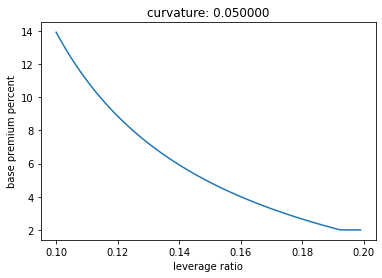

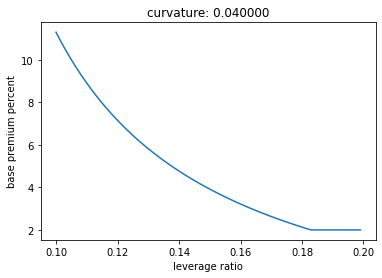

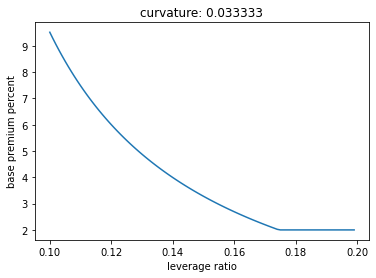

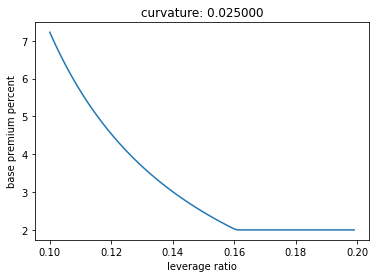

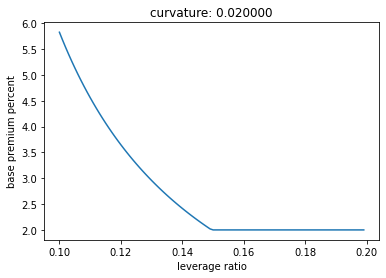

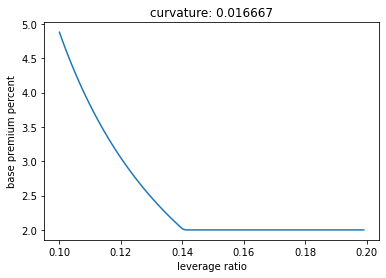

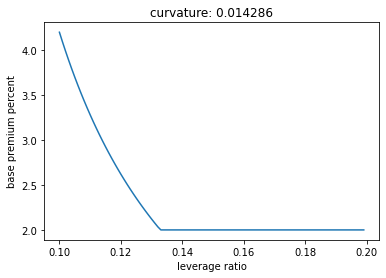

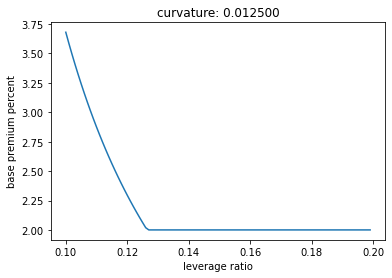

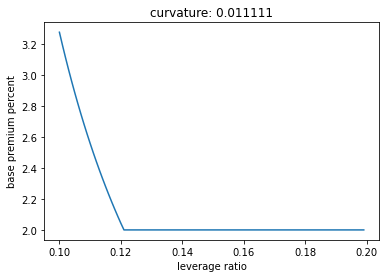

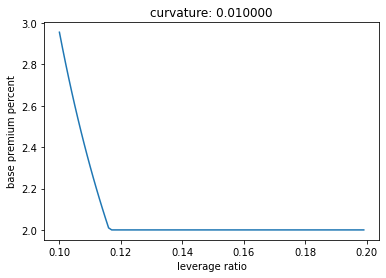

In [130]:
# base premium simulations with curvature
CURVATUREs = [1/20, 1/25, 1/30, 1 /
              40, 1 / 50, 1/60, 1/70, 1/80, 1/90, 1/100]
for curvature in CURVATUREs:
    # setting the x - coordinates with the leverage_ratios
    leverage_ratios = np.arange(LEVERAGE_RATIO_FLOOR, LEVERAGE_RATIO_CEILING, 0.001)
    base_premium_percents = [base_premium(leverage_ratio=leverage_ratio, curvature=curvature) * 100
                     for leverage_ratio in leverage_ratios]

    plt.plot(leverage_ratios, base_premium_percents)
    plt.title("curvature: %f" % (curvature))
    plt.xlabel("leverage ratio")
    plt.ylabel("base premium percent")
    plt.show()


In [131]:
# risk premium formula
def underlying_risk_premium(
    duration=DURATION,
    underlying_risk_premium_percent=UNDERLYING_RISK_PREMIUM_PERCENT,
    protection_buyer_apy=PROTECTION_BUYER_APY,
):
    underlying_risk_premium = underlying_risk_premium_percent * duration * protection_buyer_apy
    return underlying_risk_premium


In [132]:
# premium formula
def premium(
    protection_amount=PROTECTION_AMOUNT,
    duration=DURATION,
    curvature=CURVATURE,
    leverage_ratio=LEVERAGE_RATIO,
    underlying_risk_premium_percent=UNDERLYING_RISK_PREMIUM_PERCENT,
    protection_buyer_apy=PROTECTION_BUYER_APY,
    leverage_ratio_min=LEVERAGE_RATIO_MIN,
    leverage_ratio_max=LEVERAGE_RATIO_MAX,
    min_carapace_risk_premium= MIN_CARAPACE_RISK_PREMIUM,
):

    Carapace_risk_premium = carapace_risk_premium(
        duration=duration,
        curvature=curvature,
        leverage_ratio=leverage_ratio,
        leverage_ratio_min=leverage_ratio_min,
        leverage_ratio_max=leverage_ratio_max,
        min_carapace_risk_premium= min_carapace_risk_premium,
    )

    Underlying_risk_premium = underlying_risk_premium(
        duration=DURATION,
        underlying_risk_premium_percent=underlying_risk_premium_percent,
        protection_buyer_apy=protection_buyer_apy,
    )

    premium = (Carapace_risk_premium + Underlying_risk_premium) * protection_amount
    return premium


In [133]:
print(carapace_risk_premium())
print(underlying_risk_premium())

0.048770575499285984
0.017


In [134]:
#premium = base_premium + risk_premium
premium()

0.06577057549928599

0.05


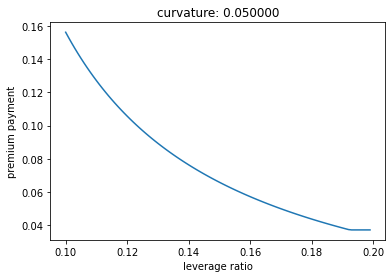

0.05


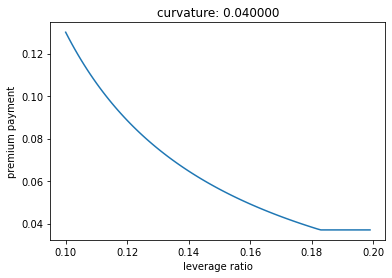

0.05


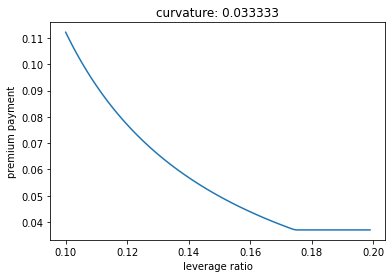

0.05


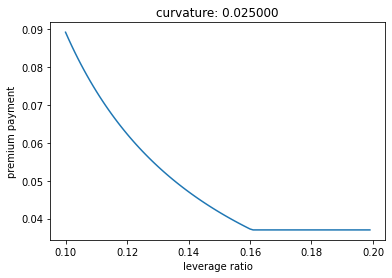

0.05


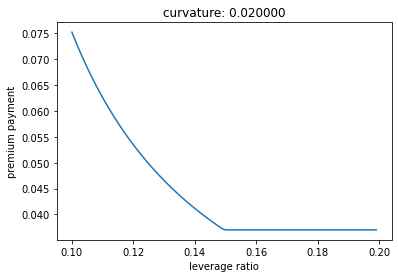

0.05


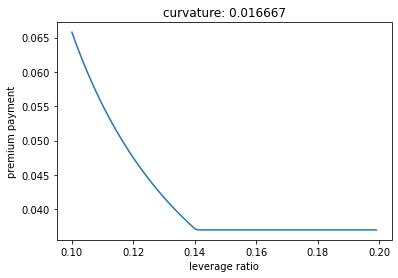

0.05


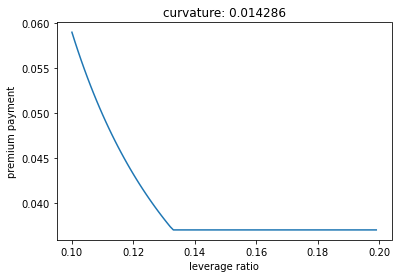

0.05


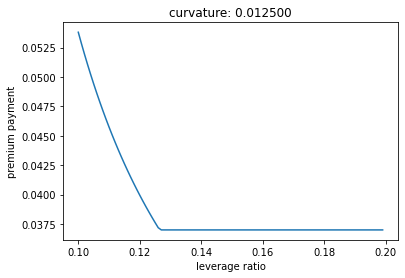

0.05


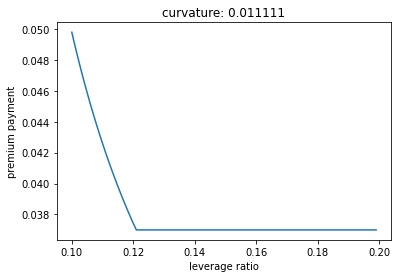

0.05


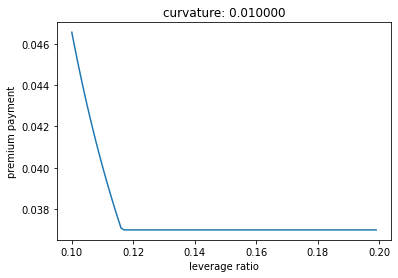

In [135]:
# premium simulation with curvatures
CURVATUREs = [1/20, 1/25, 1/30, 1 /
              40, 1 / 50, 1/60, 1/70, 1/80, 1/90, 1/100]
for curvature in CURVATUREs:
    # setting the x - coordinates with the leverage_ratios
    leverage_ratios = np.arange(0.1, 0.2, 0.001)
    premiums = [premium(leverage_ratio=leverage_ratio, curvature=curvature)
                for leverage_ratio in leverage_ratios]
    print(CURVATURE)

    plt.plot(leverage_ratios, premiums)
    plt.title("curvature: %f" % (curvature))
    plt.xlabel("leverage ratio")
    plt.ylabel("premium payment")
    plt.show()


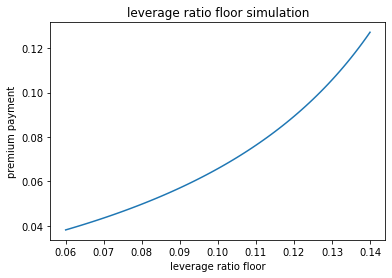

In [136]:
# the leverage ratio floor simulation. The spread is constant. 

# If the floor is lower, that means a community believes underlying loans are safe, and thus premium is cheaper.
# setting the x - coordinates
leverage_ratio_floors = np.arange(0.06, 0.14, 0.001)
premiums = [premium(leverage_ratio=0.15, leverage_ratio_min=leverage_ratio_floor - 0.05,
                    leverage_ratio_max=leverage_ratio_floor + 0.15) for leverage_ratio_floor in leverage_ratio_floors]

plt.plot(leverage_ratio_floors, premiums)
plt.title("leverage ratio floor simulation")
plt.xlabel("leverage ratio floor")
plt.ylabel("premium payment")
plt.show()


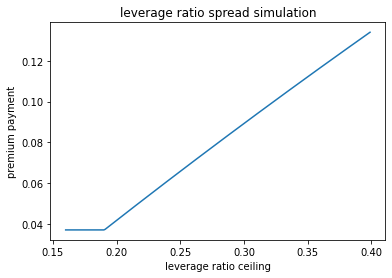

In [137]:
# the leverage ratio ceiling simulation. The floor is constant. 

# If the ceiling is lower, that means a community believes underlying loans are safe, and thus premium is cheaper.
# setting the x - coordinates
leverage_ratio_ceilings = np.arange(0.16, 0.4, 0.001)
premiums = [premium(leverage_ratio=0.15, leverage_ratio_max=leverage_ratio_ceiling)
            for leverage_ratio_ceiling in leverage_ratio_ceilings]

plt.plot(leverage_ratio_ceilings, premiums)
plt.title("leverage ratio spread simulation")
plt.xlabel("leverage ratio ceiling")
plt.ylabel("premium payment")
plt.show()


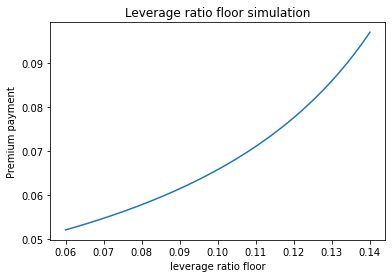

In [138]:
# the leverage ratio floor simulation. The ceiling is constant. 
# setting the x - coordinates
leverage_ratio_floors = np.arange(0.06, 0.14, 0.001)
premiums = [premium(leverage_ratio=0.15, leverage_ratio_min=leverage_ratio_floor - 0.05,) 
            for leverage_ratio_floor in leverage_ratio_floors]

# plotting the points
plt.plot(leverage_ratio_floors, premiums)
plt.title("Leverage ratio floor simulation")
plt.xlabel("leverage ratio floor")
plt.ylabel("Premium payment")
plt.show()


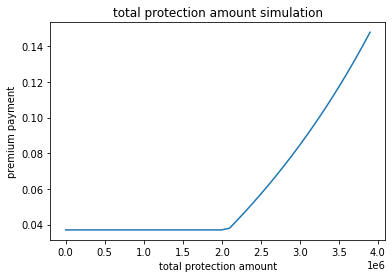

In [139]:
# total protection amount simulation
# setting the x - coordinates
total_protection_amounts = np.arange(0, 4000000, 100000)
sToken_underlying = 400000
leverage_ratios = [leverage_ratio(sToken_underlying=sToken_underlying, total_protection_amount=total_protection_amount)
                   for total_protection_amount in total_protection_amounts]
premiums = [premium(leverage_ratio=leverage_ratio)
            for leverage_ratio in leverage_ratios]

plt.plot(total_protection_amounts, premiums)
plt.title("total protection amount simulation")
plt.xlabel("total protection amount")
plt.ylabel("premium payment")
plt.show()


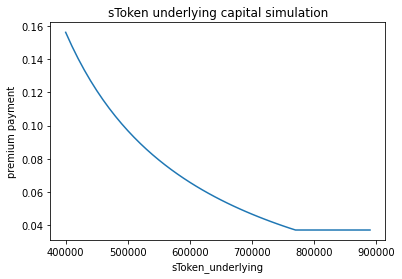

In [140]:
# sToken underlying simulation
# setting the x - coordinates
sToken_underlyings = np.arange(400000, 900000, 10000)
total_protection_amount = 4000000
leverage_ratios = [leverage_ratio(
    sToken_underlying=sToken_underlying, total_protection_amount=total_protection_amount) for sToken_underlying in sToken_underlyings]
premiums = [premium(leverage_ratio=leverage_ratio)
            for leverage_ratio in leverage_ratios]

plt.plot(sToken_underlyings, premiums)
plt.title("sToken underlying capital simulation")
plt.xlabel("sToken_underlying")
plt.ylabel("premium payment")
plt.show()


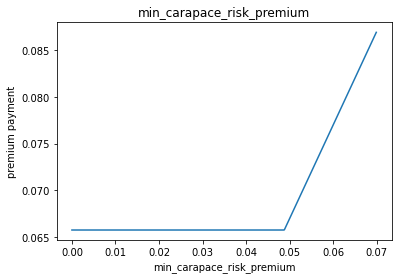

In [141]:
# min base premium simulation

# setting the x - coordinates
min_carapace_risk_premiums = np.arange(0, 0.07, 0.0001)
premiums = [premium(min_carapace_risk_premium=min_carapace_risk_premium)
            for min_carapace_risk_premium in min_carapace_risk_premiums]

plt.plot(min_carapace_risk_premiums, premiums)
plt.title("min_carapace_risk_premium")
plt.xlabel("min_carapace_risk_premium")
plt.ylabel("premium payment")
plt.show()

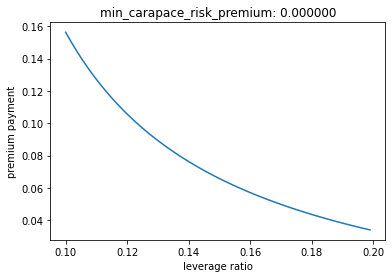

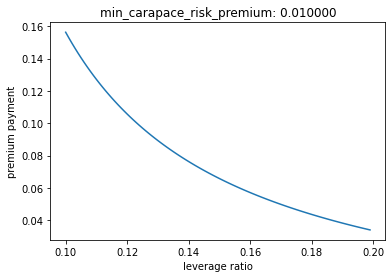

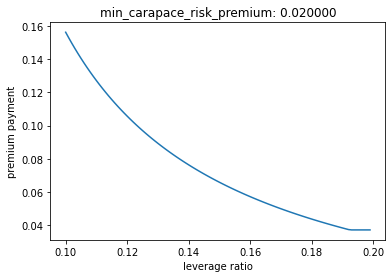

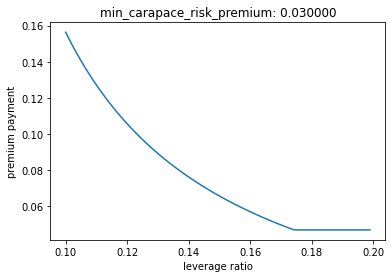

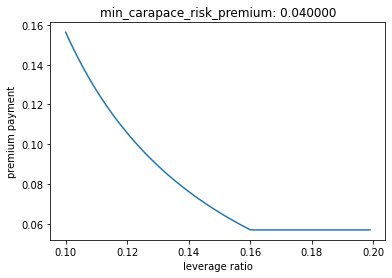

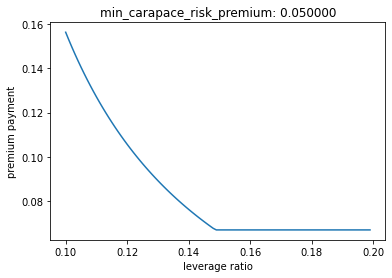

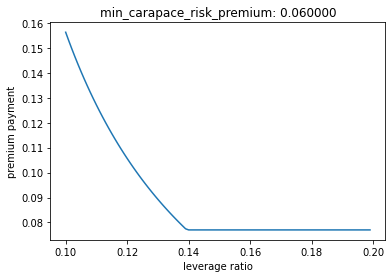

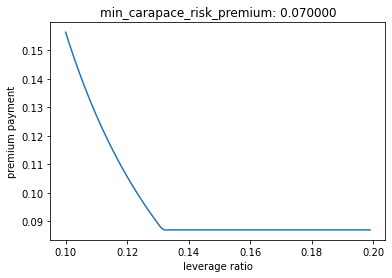

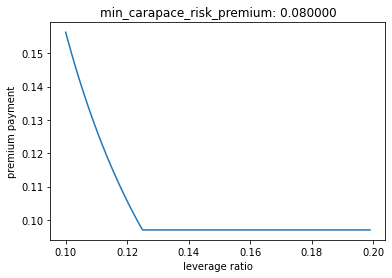

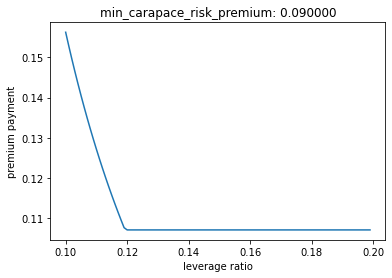

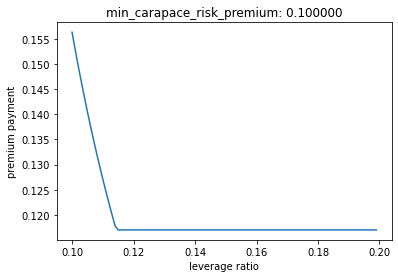

In [142]:
# min base premium simulation for different leverage_ratios

# when the leverage ratio goes close to ceiling, if the min base premium is higher, then premium becomes constant at some point
min_carapace_risk_premiums = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,0.1]
for min_carapace_risk_premium in min_carapace_risk_premiums:
    # setting the x - coordinates with the leverage_ratios
    leverage_ratios = np.arange(0.1, 0.2, 0.001)
    premiums = [premium(leverage_ratio=leverage_ratio, min_carapace_risk_premium=min_carapace_risk_premium)
                for leverage_ratio in leverage_ratios]

    plt.plot(leverage_ratios, premiums)
    plt.title("min_carapace_risk_premium: %f" % (min_carapace_risk_premium))
    plt.xlabel("leverage ratio")
    plt.ylabel("premium payment")
    plt.show()

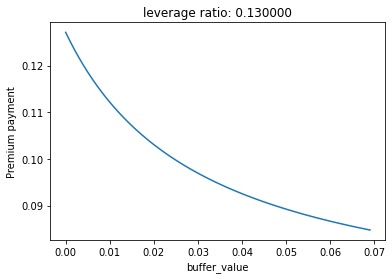

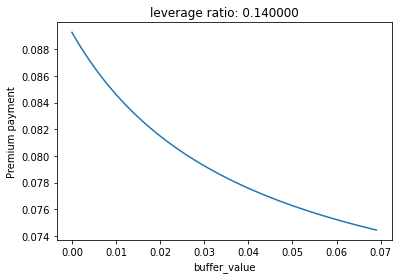

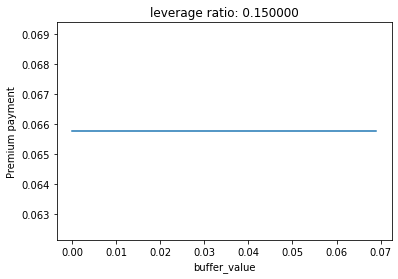

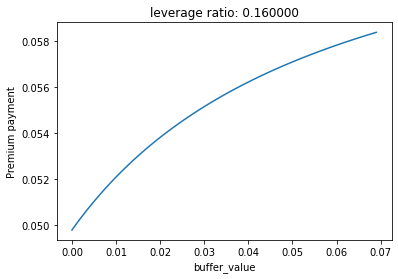

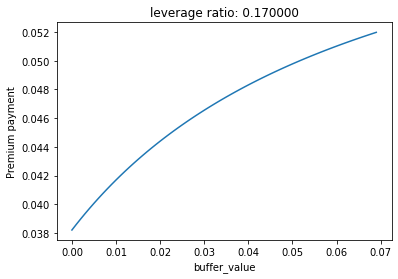

In [143]:
# buffer_value simulation
# setting the x - coordinates
buffer_values = np.arange(0, 0.07, 0.001)
for leverage_ratio in [0.13,0.14,0.15,0.16,0.17]:   
    leverage_ratio_mins = []
    leverage_ratio_maxs = []
    premiums = []
    for i in range(len(buffer_values)):
        leverage_ratio_mins.append(LEVERAGE_RATIO_FLOOR - buffer_values[i])
        leverage_ratio_maxs.append(LEVERAGE_RATIO_CEILING + buffer_values[i])
        premiums.append(premium(leverage_ratio=leverage_ratio,leverage_ratio_min=leverage_ratio_mins[i], leverage_ratio_max=leverage_ratio_maxs[i]))
    # plotting the points
    plt.plot(buffer_values, premiums)
    plt.title("leverage ratio: %f" % (leverage_ratio))
    plt.xlabel("buffer_value")
    plt.ylabel("Premium payment")
    plt.show()